In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, balanced_accuracy_score, make_scorer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import random
import shap
shap.initjs()

/Users/akosimolay/Studies/ETH Zurich/2nd semester/Machine Learning for Helath Care/project 2/Interpretability_and_Explainability/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
TRAIN_BATCH_SIZE = 16
VAL_TEST_BATCH_SIZE = 32
LEARNING_RATE = .001
SEED = 42

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

set_seed(SEED)

numerical_vars = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
categorical_vars = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease', 'FastingBS']

In [35]:
# Loading the data
scaler = MinMaxScaler()

df_train_val = pd.read_parquet('data/train_val.parquet')
df_test = pd.read_parquet('data/test.parquet')

X_train_val = df_train_val.drop('HeartDisease', axis=1)
X_train_val[numerical_vars] = scaler.fit_transform(X_train_val[numerical_vars])
X_train_val = X_train_val.to_numpy()
X_test = df_test.drop('HeartDisease', axis=1)
X_test[numerical_vars] = scaler.transform(X_test[numerical_vars])
X_test = X_test.to_numpy()

y_train_val = df_train_val['HeartDisease'].to_numpy()
y_test = df_test['HeartDisease'].to_numpy()

# Transforming the data to tensors
X_train_val = torch.from_numpy(X_train_val).float()
y_train_val = torch.from_numpy(y_train_val).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Splitting train_val into train and val 
##### LATER MAYBE KFOLD???
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.2, random_state=42, shuffle=True)

# Reshaping the outcomes to column vectors
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
#y_train_val = y_train_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Creating datasets from the tensors
train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
#train_val_data = TensorDataset(X_train_val, y_train_val)
test_data = TensorDataset(X_test, y_test)

# Creating data loaders
train_dataloader = DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)
#train_val_dataloader = DataLoader(train_val_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=VAL_TEST_BATCH_SIZE, shuffle=False)

In [36]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * TRAIN_BATCH_SIZE + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def evaluate_model(dataloader, model, loss_fn, is_test=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss = 0
    correct = 0
    preds = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            loss += loss_fn(pred, y).item()
            pred = pred.sigmoid().round()
            correct += (pred == y).type(torch.float).sum().item()
            preds.append(pred.cpu())
            labels.append(y.cpu())
            
    preds = torch.cat(preds)              
    labels = torch.cat(labels)      
    loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):.2f}%, \n Avg loss: {loss:.4f}, \n f1 score: {f1_score(labels, preds):.4f} \n Balanced accuracy: {balanced_accuracy_score(labels, preds):.4f} \n")
    
    if not is_test:
        return loss

Epoch 1
-------------------------------
loss: 0.647894  [   16/  587]
loss: 0.612235  [  176/  587]
loss: 0.766523  [  336/  587]
loss: 0.712192  [  496/  587]
Test Error: 
 Accuracy: 51.70%, 
 Avg loss: 0.6733, 
 f1 score: 0.6816 
 Balanced accuracy: 0.5000 

Epoch 2
-------------------------------
loss: 0.627388  [   16/  587]
loss: 0.690823  [  176/  587]
loss: 0.638859  [  336/  587]
loss: 0.634338  [  496/  587]
Test Error: 
 Accuracy: 51.70%, 
 Avg loss: 0.6339, 
 f1 score: 0.6816 
 Balanced accuracy: 0.5000 

Epoch 3
-------------------------------
loss: 0.606185  [   16/  587]
loss: 0.488739  [  176/  587]
loss: 0.536359  [  336/  587]
loss: 0.598383  [  496/  587]
Test Error: 
 Accuracy: 74.15%, 
 Avg loss: 0.5706, 
 f1 score: 0.7979 
 Balanced accuracy: 0.7329 

Epoch 4
-------------------------------
loss: 0.550124  [   16/  587]
loss: 0.526547  [  176/  587]
loss: 0.558463  [  336/  587]
loss: 0.463276  [  496/  587]
Test Error: 
 Accuracy: 82.99%, 
 Avg loss: 0.4970, 
 f1 

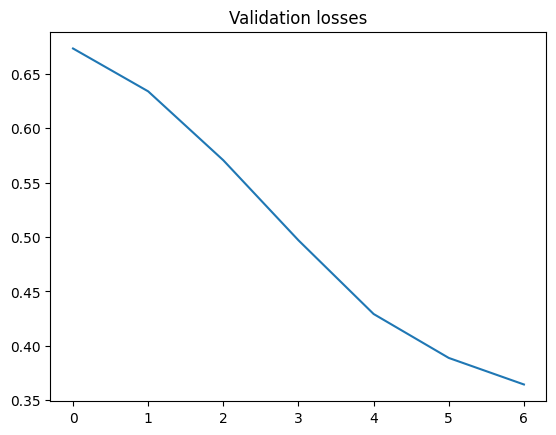

In [46]:
model = nn.Sequential(
    nn.Linear(11, 16),
    nn.ReLU(),
    #nn.Linear(32, 32),
    #nn.ReLU(),
    nn.Linear(16, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=LEARNING_RATE)

losses = []
for epoch in range(7):
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_one_epoch(train_dataloader, model, loss_fn, optimizer)
    loss = evaluate_model(val_dataloader, model, loss_fn)
    losses.append(loss)

print("Done!")

plt.plot(losses)
plt.title("Validation losses")
plt.show()

In [47]:
model.eval()
evaluate_model(test_dataloader, model, loss_fn, is_test=True)

Test Error: 
 Accuracy: 83.70%, 
 Avg loss: 0.4297, 
 f1 score: 0.8661 
 Balanced accuracy: 0.8260 



Test Error: 
 Accuracy: 83.70%, 
 Avg loss: 0.4297, 
 f1 score: 0.8661 
 Balanced accuracy: 0.8260

# Visualizing with SHAP

In [48]:
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)[:, :, 0]

/var/folders/jr/_lkl4v697jlbznhrwjmhr1t00000gn/T/ipykernel_44296/1663306337.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, df_test.drop("HeartDisease", axis=1))


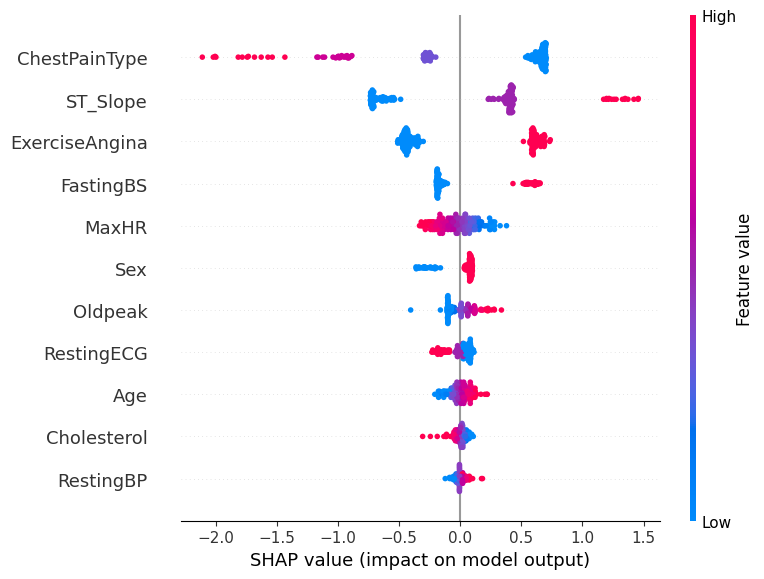

In [49]:
shap.summary_plot(shap_values, df_test.drop("HeartDisease", axis=1))

In [50]:
shap.force_plot(explainer.expected_value, shap_values, df_test.drop("HeartDisease", axis=1))